# Objective of the exercise

Can we train an analogic circuit to "learn" $x \mapsto x^2$?

In [11]:
# Define our features

from qadence import Register, FeatureParameter, chain
from qadence import AnalogRX, AnalogRY, AnalogRZ, AnalogInteraction
from qadence.draw import display
from sympy import acos

# Line register
n_qubits = 2
register = Register.line(n_qubits, spacing = 8.0)

# The input feature x for the circuit to learn f(x)
x = FeatureParameter("x")

# Feature map with a few global analog rotations
fm = chain(
    AnalogRX(x),
    AnalogRY(2*x),
    AnalogRZ(3*x),
)

In [12]:
# Ansatz quantum learning algorithm.

from qadence import hamiltonian_factory, Z
from qadence import QuantumCircuit, QuantumModel, BackendName, DiffMode
from qadence import VariationalParameter

t_0 = 1000. * VariationalParameter("t_0")
t_1 = 1000. * VariationalParameter("t_1")
t_2 = 1000. * VariationalParameter("t_2")

# Creating the ansatz with parameterized rotations and wait time.
ansatz = chain(
    AnalogRX("tht_0"),
    AnalogRY("tht_1"),
    AnalogRZ("tht_2"),
    AnalogInteraction(t_0),
    AnalogRX("tht_3"),
    AnalogRY("tht_4"),
    AnalogRZ("tht_5"),
    AnalogInteraction(t_1),
    AnalogRX("tht_6"),
    AnalogRY("tht_7"),
    AnalogRZ("tht_8"),
    AnalogInteraction(t_2),
)

In [13]:
# Wrap everything as an observable.

# Total magnetization observable
observable = hamiltonian_factory(n_qubits, detuning = Z)

# Defining the circuit and observable
circuit = QuantumCircuit(register, fm, ansatz)

model = QuantumModel(
    circuit,
    observable = observable,
    backend = BackendName.PYQTORCH,
    diff_mode = DiffMode.AD
)

In [14]:
# Prepare the curve we want to approximate.

import torch
import matplotlib.pyplot as plt

# Function to fit:
def f(x):
    return x**2

x_test = torch.linspace(-1.0, 1.0, steps=100)
y_test = f(x_test)

x_train = torch.linspace(-1.0, 1.0, steps=10)
y_train = f(x_train)

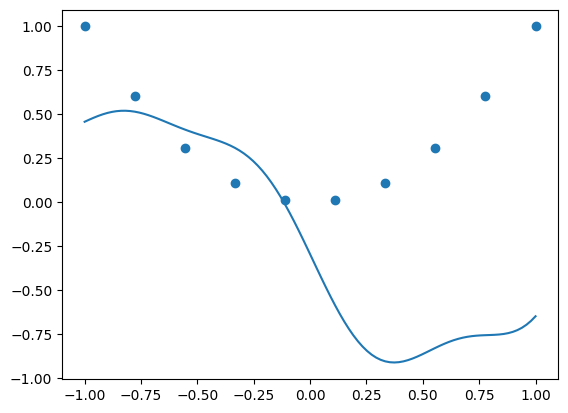

In [15]:
# Before learning...

# Initial prediction from the model, to be visualized later
y_pred_initial = model.expectation({"x": x_test}).detach()

plt.plot(x_test, y_pred_initial, label = "Initial prediction")
plt.scatter(x_train, y_train, label = "Training points")

In [16]:
# Run a few steps of the learning algorithm.

mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

def loss_fn(x_train, y_train):
    out = model.expectation({"x": x_train})
    loss = mse_loss(out.squeeze(), y_train)
    return loss

n_epochs = 200

for i in range(n_epochs):
    optimizer.zero_grad()
    loss = loss_fn(x_train, y_train)
    loss.backward()
    optimizer.step()

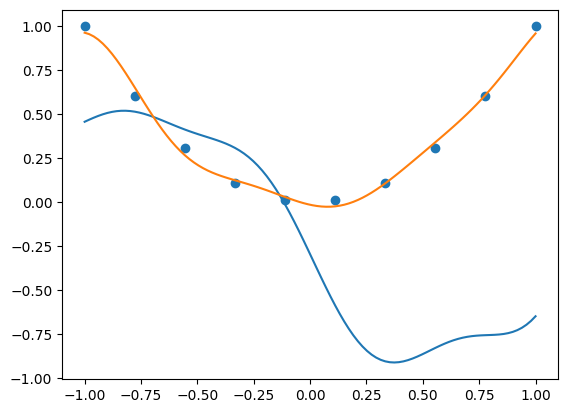

In [17]:
# Does it look good?

y_pred_final = model.expectation({"x": x_test}).detach()

plt.plot(x_test, y_pred_initial, label = "Initial prediction")
plt.plot(x_test, y_pred_final, label = "Final prediction")
plt.scatter(x_train, y_train, label = "Training points")